### Import python packages

In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

In [2]:
from yahooquery import Ticker

In [3]:
import torch
import torch.utils.data
from torch import optim
from torch import nn
from torch.autograd import Variable

In [24]:
from ibov.utils import load_config
from ibov.feature import create_lags
from ibov.training import IbovModel, train

### Load Data

In [5]:
config = load_config()

In [6]:
data_root_dir = config["data"]["root"]

In [7]:
ibov = Ticker(symbols = config["ibovespa"]["ticker"])
ibov_data = ibov.history(period="max")
ibov_data.to_csv(f"{data_root_dir}/ibovespa.csv")

### Geração dos conjuntos de dados de treino

In [8]:
dados_ibov = pd.read_csv(f"{data_root_dir}/ibovespa.csv")

In [9]:
amostra = dados_ibov[["date", "close"]].tail(1000).sort_values(by="date", ascending=False).reset_index(drop=True)
amostra.head()

,date,close
0,2020-12-30,119306.0
1,2020-12-29,119475.0
2,2020-12-28,119051.0
3,2020-12-23,117857.0
4,2020-12-22,116348.0


In [10]:
window = config["feature"]["window"]

In [11]:
trainY, trainX = create_lags(data = amostra["close"], window = window)

### Definição do modelo

#### Test Net

random_data = torch.rand((1, 1, 7))
test_net = Net(window=window)
result = test_net(random_data)
print(result)

### Train Net

In [12]:
tensor_x = torch.Tensor(np.array(trainX))
tensor_y = torch.Tensor(np.array(trainY))

In [14]:
dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [25]:
model = IbovModel(window=window)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
train(dataloader, model, criterion, optimizer, epochs=10)

51315895792.0
24258290988.0
19037751718.0
14597717804.5
12096056580.0
9989375110.0
8596161485.0
7701575854.0
7897543936.5
7130233427.0


<bound method Module.eval of IbovModel(
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=7, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)>

In [32]:
import seaborn as sns

In [72]:
prediction = np.hstack(model(tensor_x).detach().numpy()).tolist()
true_value = np.hstack(trainY).tolist()
evaluation_data = pd.DataFrame(columns=["pred", "true"])
evaluation_data["pred"] = prediction
evaluation_data["true"] = true_value
evaluation_data.head()

,pred,true
0,119237.031250,119306.0
1,114877.609375,119475.0
2,111850.671875,119051.0
3,102419.671875,117857.0
4,138524.843750,116348.0


In [73]:
from matplotlib import pyplot

<AxesSubplot:>

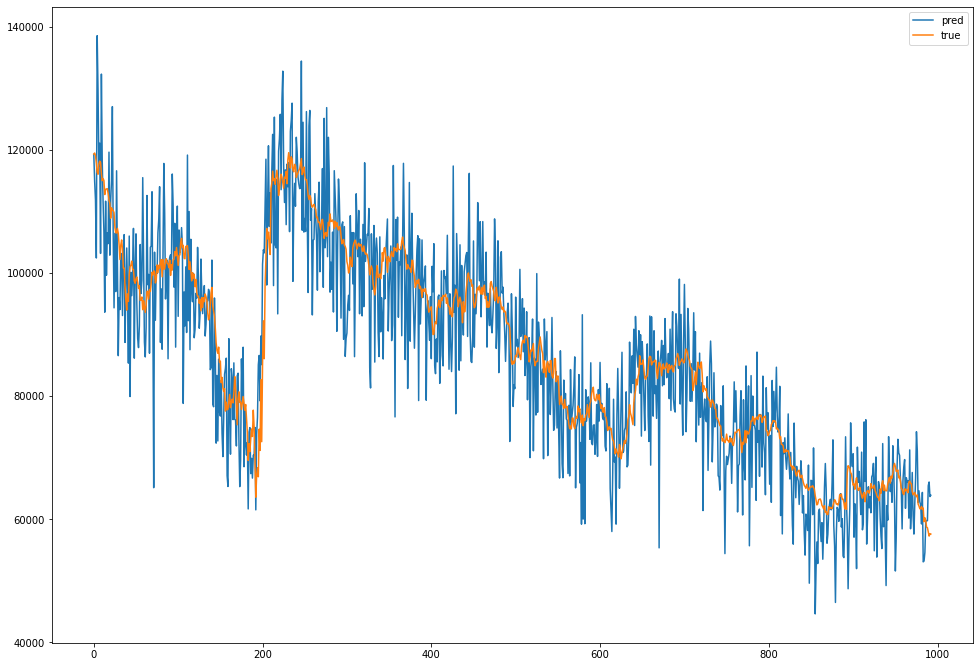

In [78]:
a4_dims = (16.5, 11.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.lineplot(ax=ax, data=evaluation_data, dashes=False)